In [ ]:
#   This progeam uses artifictal recurrent neutral network called Long Short Term Momory (LSTM) to
#   predict the closing stock price of a corporation using the past 60 day stock price

In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# Get Stock Data
stock_data = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-10-22')
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.610314
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.678083
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.818834
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.952839
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.932295
...,...,...,...,...,...,...
2021-10-18,146.839996,143.160004,143.449997,146.550003,85589200.0,146.550003
2021-10-19,149.169998,146.550003,147.009995,148.759995,76378900.0,148.759995
2021-10-20,149.750000,148.119995,148.699997,149.259995,58418800.0,149.259995


In [4]:
stock_data.shape

(2469, 6)

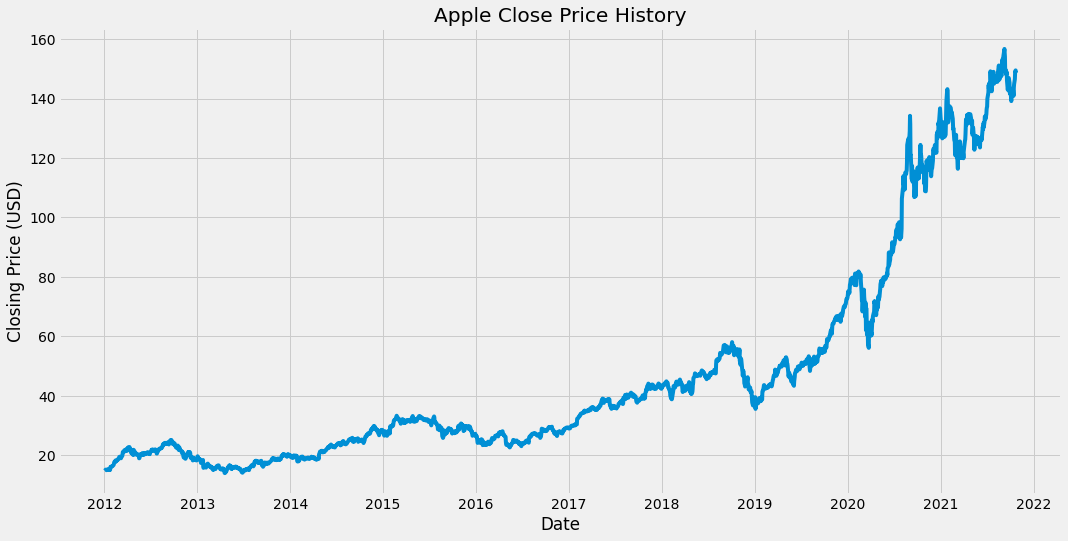

In [5]:
# Visualize the closing price history
plt.figure(figsize=(16, 8))
plt.title('Apple Closing Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()

In [11]:
# Create a new dataframe with only the close column
close = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
close_array = close.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(close_array) * 0.8)

training_data_len

1976

In [12]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_array)

scaled_data

array([[0.00517915],
       [0.00573209],
       [0.00688052],
       ...,
       [0.94794817],
       [0.94948942],
       [0.94395502]])

In [13]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]
# Split the data into x_train and y_train
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [14]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [16]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1916, 60, 1)

In [18]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1916/1916 [==============================] - 80s 40ms/step - loss: 2.5479e-04


In [21]:
# Create the testing dataset
# Create a new array containing scaled values from index 1916 to 2469
test_data = scaled_data[training_data_len - 60: 2469: , :]
# Create the datasets x_test and y_test
x_test = []
y_test = close_array[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


In [22]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [23]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [24]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [25]:
# Get the RMSE
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.5560562257592625

<ipython-input-26-11011b179f38>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


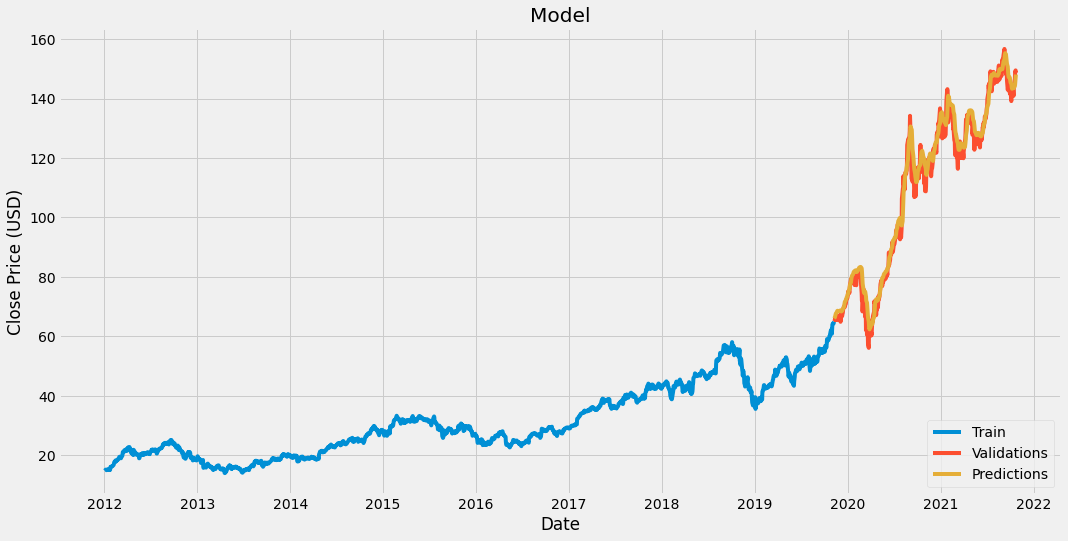

In [26]:
# PLot the data
train = close[:training_data_len]
valid = close[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Validations", "Predictions"], loc="lower right")
plt.show()

In [27]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-11-08,65.035004,65.989006
2019-11-11,65.550003,66.396118
2019-11-12,65.489998,66.793243
2019-11-13,66.117500,67.131264
2019-11-14,65.660004,67.472923
...,...,...
2021-10-18,146.550003,144.171097
2021-10-19,148.759995,144.869919
2021-10-20,149.259995,145.896118


In [28]:
# Predicting the price for the next day
# Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-10-22')
# Create new dataframe
new_df = apple_quote.filter(['Close'])
# Get the last 60 day closing price calues and convert the dataframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be the values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append last 60 days to list
X_test.append(last_60_days_scaled)
# Convert the X_test dataset to a numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
pred_price

array([[148.87743]], dtype=float32)